#  Supervised ML on Imbalanced Dataset
In this notebook, we train three classifiers on the imbalanced dataset by implementing cost sensitive method, undersampling, and SMOTE

In [21]:
%matplotlib inline

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set font scale and style
plt.rcParams.update({'font.size': 15})

# Dimensionality reduction
from sklearn.decomposition import PCA

# Resampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Machine learning models
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Grid search and model selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

# Model performance metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, auc,recall_score
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, precision_recall_curve

# Pickle
import joblib

In [22]:
# Import custom class
%run -i '../src/helper/transfxn.py'
%run -i '../src/helper/ml.py'

# Load data

In [5]:
df = pd.read_csv('../data/ml_data.csv') # Load cleaned data
df = df.sample(frac =1).reset_index(drop = True) # shuffle
print('Data size',df.shape) # data size
df.head()

Data size (3817613, 23)


,c_year,c_mnth,c_wday,c_hour,fatal,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user,c_case
0,2003,August,Friday,16.0,0,2.0,other,At an intersection,Clear and sunny,Normal,...,Light Duty Vehicle,1999.0,2.0,F,55.0,Front row,No Injury,Safety device used,Motor Vehicle Passenger,628205
1,2005,January,Saturday,10.0,0,2.0,Rear-end collision,At an intersection,Clear and sunny,Normal,...,Light Duty Vehicle,2004.0,5.0,M,2.0,Second row,No Injury,Safety device used,Motor Vehicle Passenger,970737
2,2003,February,Sunday,18.0,0,1.0,other,other,Visibility limitation,Wet,...,Light Duty Vehicle,1999.0,1.0,M,32.0,Driver,No Injury,Safety device used,Motor Vehicle Driver,728617
3,2002,May,Monday,17.0,0,3.0,other,At an intersection,Raining,Wet,...,Light Duty Vehicle,1988.0,1.0,M,37.0,Driver,No Injury,Safety device used,Motor Vehicle Driver,474361
4,2002,April,Monday,19.0,0,2.0,Any other two-vehicle - different direction,Intersection with parking lot entrance,Clear and sunny,Normal,...,other,1997.0,1.0,M,26.0,Driver,No Injury,Safety device used,Motor Vehicle Driver,513462


# Class distribution

In [6]:
df.fatal.value_counts(normalize = True)*100

0    98.394049
1     1.605951
Name: fatal, dtype: float64

# Develop model with reduced dataset
The dataset is very large to fit in a small laptop memory, training the entire dataset on a laptop will take days to run let alone tuning the hyperparameters by grid search.  Hence, we will first split the dataset into two subsets and train the model on the small subset

In [7]:
X1, X2, y1, y2 = train_test_split(df, df.fatal, test_size = 0.003, random_state = 42, stratify = df.fatal)

In [8]:
print('Large subset size:', X1.shape, y1.shape)
print('Small subset size:', X2.shape, y2.shape)

Large subset size: (3806160, 23) (3806160,)
Small subset size: (11453, 23) (11453,)


In [9]:
# Pickle the small subset
X2.to_pickle('../data/collision.pkl')

# Prepare the reduced dataset for machine learning

In [10]:
# Reload the small subset
df_small = pd.read_pickle('../data/collision.pkl')

In [11]:
# Feature matrix and class label
cols_to_drop = ['c_wday','p_id', 'v_id', 'fatal']
X, y = df_small.drop(cols_to_drop, axis = 1), df_small.fatal

In [12]:
print('Data size:', X.shape, y.shape)

Data size: (11453, 19) (11453,)


## Create a Test Set
We now split the data set into $80\%$ training set and $20\%$ test set in a stratify fashion

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify = y)

In [14]:
print('Training set size:', X_train.shape, y_train.shape)
print('Test set size:', X_test.shape, y_test.shape)

Training set size: (9162, 19) (9162,)
Test set size: (2291, 19) (2291,)


In [15]:
print('Training set class distribution:\n', (y_train.value_counts()/X_train.shape[0])*100)
print('--' * 15)
print('Test set class distribution:\n', (y_test.value_counts()/X_test.shape[0])*100)

Training set class distribution:
 0    98.395547
1     1.604453
Name: fatal, dtype: float64
------------------------------
Test set class distribution:
 0    98.384985
1     1.615015
Name: fatal, dtype: float64


## Transformation pipeline

In [16]:
# Instantiate the class
transfxn = TransformationPipeline()

In [17]:
# Transform and scale data
X_train_scaled, X_test_scaled, feat_names = transfxn.preprocessing(X_train, X_test)

In [18]:
# Size of the data after pre-processing
print('Training set size after pre-processing:', X_train_scaled.shape)
print('Test set size after pre-processing:', X_test_scaled.shape)

Training set size after pre-processing: (9162, 80)
Test set size after pre-processing: (2291, 80)


In [19]:
# Convert the class labels to arrays
y_train, y_test = y_train.values,  y_test.values

# A. Model Selection by Cross-Validation

In this section, we train 4 different supervised ML models on the imbalanced dataset: 

1). Logistic Regression

2). Support Vector Machine classifier

3). Random Forest classifier

4). XGBoost classifier

The results show that the overall accuracy of the models is not a good  performance measure on the imbalanced datasets, as it is biased towards the majority (negative) class. Therefore, we shall select and optimize the model with the best area under the receiver operating charateristics curve (AUROC) and the best precision-recall (AUPR) curve. 

In [23]:
# Instantiate the class
model = SupervisedModels()

## A-1. Logistic Regression

In [24]:
log_clf = LogisticRegression()   
model.eval_metrics_cv(log_clf, X_train_scaled, y_train, cv_fold = 5, 
scoring = 'accuracy', model_nm = "Logistic Regression")

5-Fold cross-validation results for Logistic Regression
------------------------------------------------------------
Accuracy (std): 0.989958 (0.002331)
AUROC: 0.865781
AUPRC: 0.522716
Predicted classes: [0 1]
Confusion matrix:
 [[9013    2]
 [  90   57]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      9015
           1       0.97      0.39      0.55       147

    accuracy                           0.99      9162
   macro avg       0.98      0.69      0.77      9162
weighted avg       0.99      0.99      0.99      9162

------------------------------------------------------------


## A-1-1.  Hyperparameter tuning - LR
 In this section, we shall optimize the **AUC** of the classifiers using grid/randomized search, cross-validation, and cost sensitive method

In [161]:
# Class ratio of the negative class to the positive class
neg = y_train == 0
pos = y_train == 1
class_ratio = np.sum(neg)/np.sum(pos)
class_ratio

61.326530612244895

In [162]:
# Range of hyperparameters
params = {'C': [2**x for x in range(-2,9,2)], 
        'class_weight': ['balanced', {0:1, 1:2}, {0:1, 1:3},
                         {0:1, 1:class_ratio}]}
                             
# Grid search
gsearch_log = RandomizedSearchCV(estimator = log_clf, param_distributions = params, 
                                scoring = 'roc_auc', cv = 5, n_jobs = -1, n_iter = 200, 
                                random_state = 42, verbose = 1)

# Fit the  training set
gsearch_log.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(gsearch_log.best_estimator_, '../data/log_clf.pkl')

# Print results
print('Grid search best AUC score:', gsearch_log.best_score_)
print('Grid search best parameters:', gsearch_log.best_params_)    

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Grid search best AUC score: 0.8947557391575982
Grid search best parameters: {'class_weight': {0: 1, 1: 2}, 'C': 0.25}


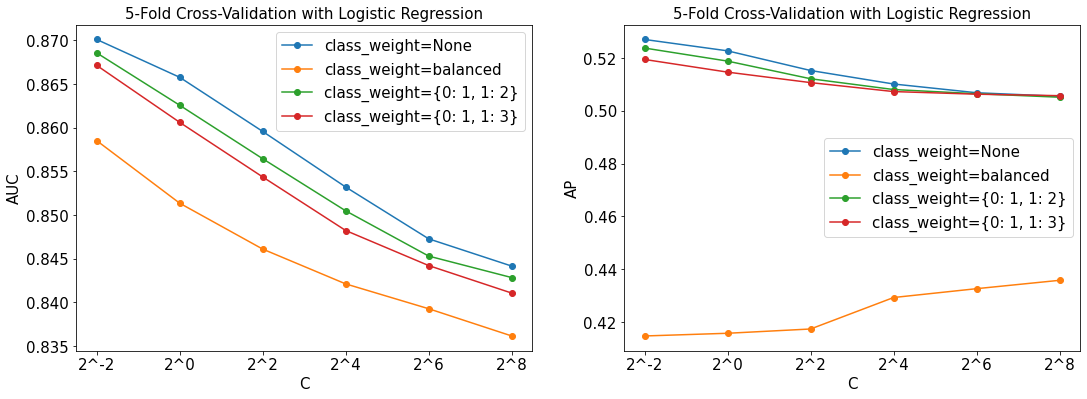

In [25]:
model.plot_auc_ap_lr(X_train_scaled, y_train, cv_fold = 5)

## A-2. Support Vector Machine

In [26]:
svm_clf = SVC(probability = True, kernel = 'rbf')   
model.eval_metrics_cv(svm_clf, X_train_scaled, y_train, cv_fold = 5, 
scoring = 'accuracy', model_nm = "SVM Classifier")

5-Fold cross-validation results for SVM Classifier
------------------------------------------------------------
Accuracy (std): 0.990068 (0.001840)
AUROC: 0.854137
AUPRC: 0.485004
Predicted classes: [0 1]
Confusion matrix:
 [[9015    0]
 [  91   56]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      9015
           1       1.00      0.38      0.55       147

    accuracy                           0.99      9162
   macro avg       1.00      0.69      0.77      9162
weighted avg       0.99      0.99      0.99      9162

------------------------------------------------------------


## A-2-1. Hyperparameter tuning- SVM

In [50]:
# Range of hyperparameters
params = {'C': [2**x for x in range(-2,11,2)], 
          'gamma': [2**x for x in range(-11,1,2)],
          'class_weight': [None, {0:1, 1:3},{0:1, 1:5},
                           {0:1, 1:7},{0:1, 1:10}]
         } 
                                                              
# Randomized search for SVM
svm_clf = SVC(probability = True, kernel = 'rbf')
rsearch_svm = RandomizedSearchCV(svm_clf, param_distributions = params, cv = 5,
                                 scoring = 'roc_auc', n_iter =200,
                                 n_jobs = -1,random_state = 42, verbose = 1) 
# Fit the training set
rsearch_svm.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_svm.best_estimator_, '../data/svm_clf.pkl')

print('Best score: ', rsearch_svm.best_score_)
print('Best parameters: ', rsearch_svm.best_params_)  

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best score:  0.9059599263041802
Best parameters:  {'gamma': 0.00048828125, 'class_weight': {0: 1, 1: 7}, 'C': 16}


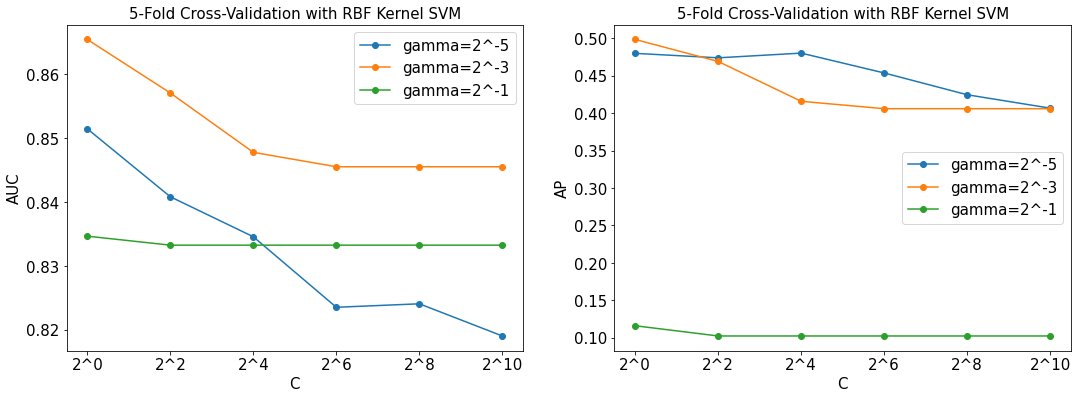

In [27]:
model.plot_auc_ap_svm(X_train_scaled, y_train, cv_fold = 5)

## A-3. Random Forest

In [28]:
rf_clf = RandomForestClassifier(random_state = 42)                         
model.eval_metrics_cv(rf_clf, X_train_scaled, y_train, cv_fold = 5, 
                        scoring = 'accuracy', model_nm = "Random Forest Classifier")

5-Fold cross-validation results for Random Forest Classifier
------------------------------------------------------------
Accuracy (std): 0.990177 (0.001953)
AUROC: 0.843197
AUPRC: 0.493514
Predicted classes: [0 1]
Confusion matrix:
 [[9015    0]
 [  90   57]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      9015
           1       1.00      0.39      0.56       147

    accuracy                           0.99      9162
   macro avg       1.00      0.69      0.78      9162
weighted avg       0.99      0.99      0.99      9162

------------------------------------------------------------


## A-3-1.  Hyperparameter tuning - RF

In [52]:
# Range of hyperparameters
params = {'max_features': [0.5, 1, 'sqrt', 'log2', None], 
        'class_weight': [None, 'balanced', 'balanced_subsample', 
                         {0: 1, 1: 2}, {0: 1, 1: class_ratio}]}

# Randomized search
rf_clf = RandomForestClassifier(n_estimators = 2000, random_state = 42)           
rsearch_rf = RandomizedSearchCV(estimator = rf_clf, param_distributions = params, 
                                scoring = 'roc_auc', cv = 5, n_jobs = -1, n_iter = 200, 
                                random_state = 42, verbose = 1)  
# Fit the  training set                                                    
rsearch_rf.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_rf.best_estimator_, '../data/rf_clf.pkl')

# Print results
print('Randomized search best AUC score:', rsearch_rf.best_score_) 
print('Randomized search best hyperparameters:', rsearch_rf.best_params_) 

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Randomized search best AUC score: 0.9094465800932034
Randomized search best hyperparameters: {'n_estimators': 2000, 'max_features': 0.5, 'class_weight': {0: 1, 1: 61.326530612244895}}


Text(0.5, 1.0, 'Top 20 Feature Importances')

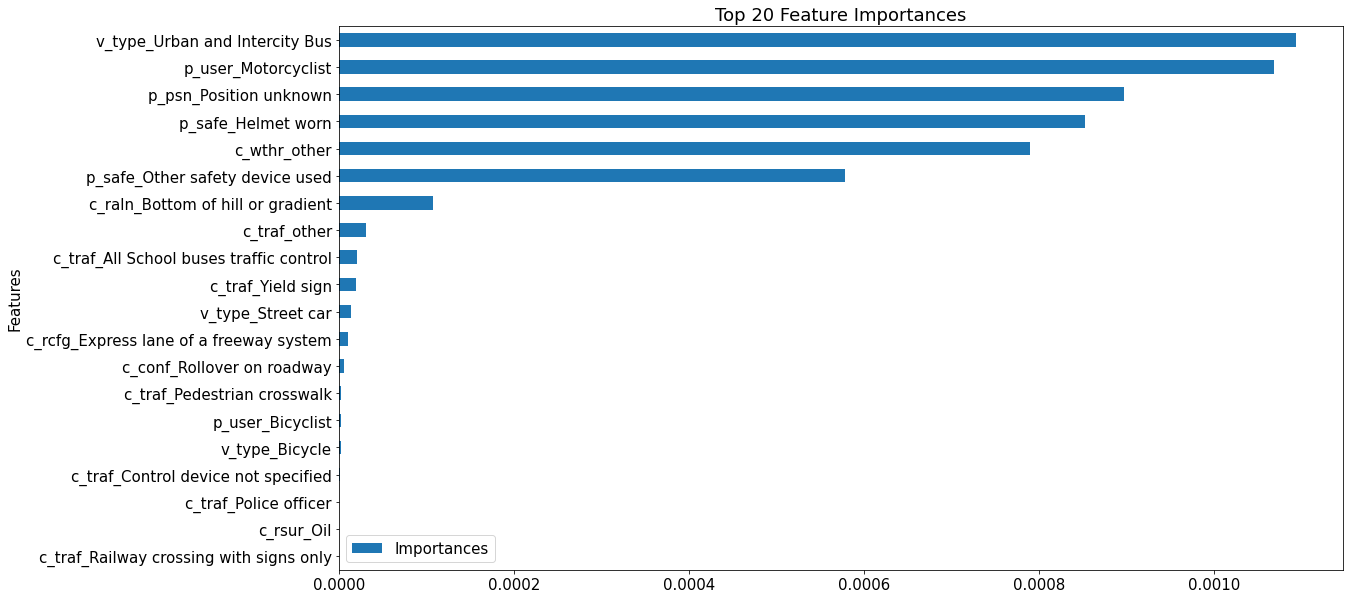

In [29]:
# Load trained model
rf_clf = joblib.load('../data/rf_clf.pkl')

# Compute feature importances
importances_df = pd.DataFrame({'Features': feat_names, 'Importances': rf_clf.feature_importances_})

# Bar plot
importances_df.sort_values('Importances', ascending = True, inplace = True)
importances_df.set_index('Features', inplace = True)
importances_df.head(20).plot(kind='barh', figsize = (18,10))
plt.title('Top 20 Feature Importances for Random Forest Classifier')

## A-4. XGBoost

In [46]:
param_dist = {'objective':'binary:logistic', 'eval_metric':'logloss', 'random_state':42}
xgb_clf = XGBClassifier(**param_dist) 
model.eval_metrics_cv(xgb_clf, X_train_scaled, y_train, cv_fold = 5,
                        scoring = 'accuracy', model_nm = "XGBoost Classifier")

5-Fold cross-validation results for XGBoost Classifier
------------------------------------------------------------
Accuracy (std): 0.989631 (0.002489)
AUROC: 0.855833
AUPRC: 0.477952
Predicted classes: [0 1]
Confusion matrix:
 [[9007    8]
 [  87   60]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      9015
           1       0.88      0.41      0.56       147

    accuracy                           0.99      9162
   macro avg       0.94      0.70      0.78      9162
weighted avg       0.99      0.99      0.99      9162

------------------------------------------------------------


## A-4-1. Hyperparameter tuning  - XGB

In [55]:
# Range of hyperparameters
params = {'subsample':[i/10 for i in range(5,9)],'colsample_bytree': [i/10 for i in range(5,9)]}

# Randomized search
xgb_clf = XGBClassifier(n_estimators = 2000, random_state = 42,
                              scale_pos_weight = class_ratio, learning_rate = 0.1, 
                              min_child_weight = 5, max_depth = 9)
rsearch_xgb = RandomizedSearchCV(estimator = xgb_model, param_distributions = params, 
                                  scoring = 'roc_auc', cv = 5, n_jobs = -1, n_iter = 200, 
                                  random_state = 42, verbose = 1)  
# Fit the  training set                                                            
rsearch_xgb.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_xgb.best_estimator_, '../data/xgb_clf.pkl')

# Print results
print('Randomized search best AUC score:', rsearch_xgb.best_score_) 
print('Randomized search best hyperparameters:', rsearch_xgb.best_params_) 

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Randomized search best AUC score: 0.9065009148226773
Randomized search best hyperparameters: {'subsample': 0.5, 'colsample_bytree': 0.8}


Text(0.5, 1.0, 'Top 20 Feature Importances for XGBoost Classifier')

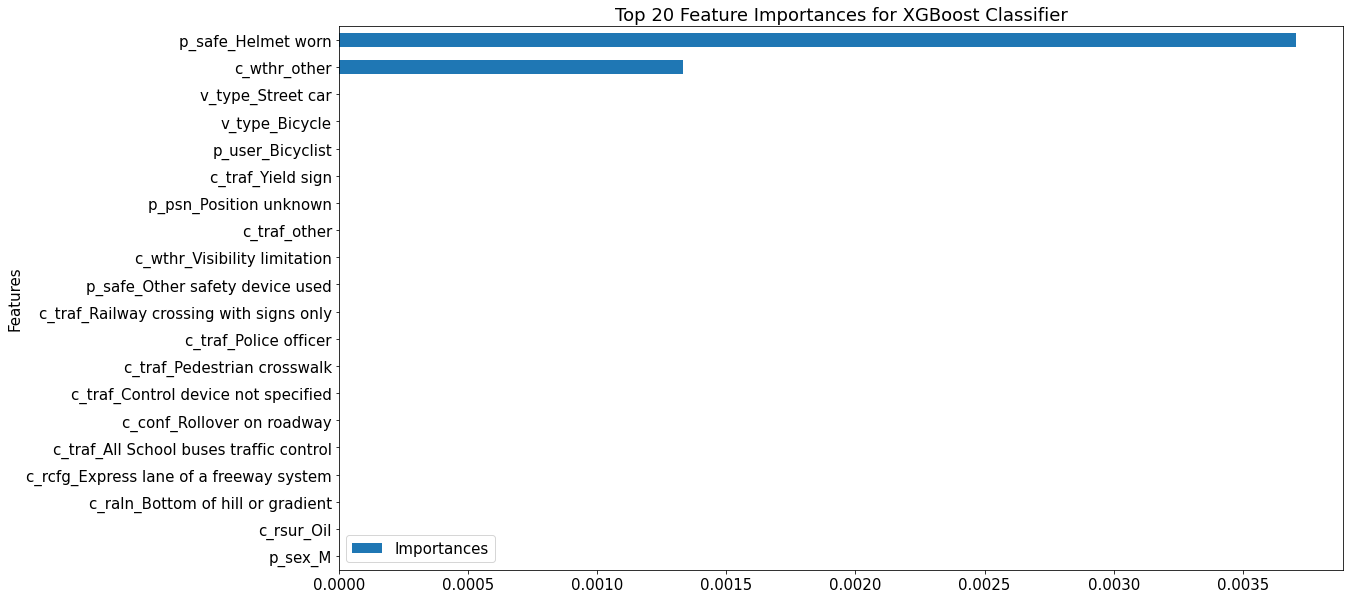

In [47]:

# Compute feature importances
importances_df = pd.DataFrame({'Features': feat_names,
                                 'Importances': xgb_clf.feature_importances_})

# Bar plot
importances_df.sort_values('Importances', ascending = True, inplace = True)
importances_df.set_index('Features', inplace = True)
importances_df.head(20).plot(kind='barh', figsize = (18,10))
plt.title('Top 20 Feature Importances for XGBoost Classifier')

# C. Resampling Methods
In this section, we will employ two resampling techniques on the training set to balance the classes. However, the final prediction will be made on the imbalanced test set. The idea of resampling is to trick the classifier using a balanced dataset.  

## C-1. Under Sampling  combined with Random Forest Classifier
In undersampling, we reduce the majority class such that it matches the minority class

In [48]:
# Under sample the majority class
und = RandomUnderSampler(random_state = 42)
X_train_scaled_und, y_train_und = und.fit_resample(X_train_scaled, y_train)

In [49]:
print('Undersampled training data size:', X_train_scaled_und.shape, y_train_und.shape)

Undersampled training data size: (294, 80) (294,)


In [50]:
print('Imbalanced training set class distribution:', np.bincount(y_train))
print('Undersampled training set class distribution:', np.bincount(y_train_und))

Imbalanced training set class distribution: [9015  147]
Undersampled training set class distribution: [147 147]


In [51]:
# Random Forest Classifier cross-validation on the undersampled dataset
rf_und = RandomForestClassifier(n_estimators = 1000,random_state = 42)
model.eval_metrics_cv(rf_und, X_train_scaled_und, y_train_und, cv_fold = 5, 
scoring = 'accuracy', model_nm = "Undersampling with Random Forest Classifier")

5-Fold cross-validation results for Undersampling with Random Forest Classifier
------------------------------------------------------------
Accuracy (std): 0.799182 (0.023860)
AUROC: 0.897843
AUPRC: 0.906623
Predicted classes: [0 1]
Confusion matrix:
 [[123  24]
 [ 35 112]]
Classification report:
               precision    recall  f1-score   support

           0       0.78      0.84      0.81       147
           1       0.82      0.76      0.79       147

    accuracy                           0.80       294
   macro avg       0.80      0.80      0.80       294
weighted avg       0.80      0.80      0.80       294

------------------------------------------------------------


## C-2. SMOTE  combined with Random Forest Classifier
In Synthetic Minority Over Sampling Technique (SMOTE), we generate synthetic oberservations to match the minority clas.
SMOTE oversampled the minority class in the training set, so we now have equal class distribution. 

In [52]:
# Over sample the minority class
sm = SMOTE(random_state = 42)
X_train_scaled_ovsm, y_train_ovsm = sm.fit_resample(X_train_scaled, y_train)

In [53]:
print('SMOTE training data size:', X_train_scaled_ovsm.shape, y_train_ovsm.shape)

SMOTE training data size: (18030, 80) (18030,)


In [54]:
print('Imbalanced training set class distribution:', np.bincount(y_train))
print('SMOTE resampled training set class distribution:', np.bincount(y_train_ovsm))

Imbalanced training set class distribution: [9015  147]
SMOTE resampled training set class distribution: [9015 9015]


In [55]:
# Random Forest cross-validation on the SMOTE dataset
rf_ovsm = RandomForestClassifier(random_state = 42)
model.eval_metrics_cv(rf_ovsm, X_train_scaled_ovsm, y_train_ovsm, cv_fold = 5, 
scoring = 'accuracy', model_nm = "SMOTE with Random Forest Classifier")

5-Fold cross-validation results for SMOTE with Random Forest Classifier
------------------------------------------------------------
Accuracy (std): 0.995729 (0.007849)
AUROC: 0.999808
AUPRC: 0.999804
Predicted classes: [0 1]
Confusion matrix:
 [[9010    5]
 [  72 8943]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      9015
           1       1.00      0.99      1.00      9015

    accuracy                           1.00     18030
   macro avg       1.00      1.00      1.00     18030
weighted avg       1.00      1.00      1.00     18030

------------------------------------------------------------


# D. Prediction on the Imbalanced Test Set 
In this section, we make our final prediction on the imbalanced dataset after training the model using the resampling techniques.

## D-1. Normal Imbalanced Dataset

In [56]:
rf_clf = joblib.load('../data/rf_clf.pkl') # Load trained model
model.test_pred(rf_clf, X_train_scaled, y_train, X_test_scaled, y_test, 
                    model_nm = "Random Forest Classifier")

Test predictions for Random Forest Classifier
------------------------------------------------------------
Accuracy:  0.987778
AUROC: 0.764803
AUPRC: 0.351661
Predicted classes: [0 1]
Confusion matrix:
 [[2254    0]
 [  28    9]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      2254
           1       1.00      0.24      0.39        37

    accuracy                           0.99      2291
   macro avg       0.99      0.62      0.69      2291
weighted avg       0.99      0.99      0.98      2291

------------------------------------------------------------


## D-2. Undersampled Dataset

In [57]:
model.test_pred(rf_und, X_train_scaled_und, y_train_und, X_test_scaled, y_test,
                model_nm = "UnderSampling with Random Forest Classifier")

Test predictions for UnderSampling with Random Forest Classifier
------------------------------------------------------------
Accuracy:  0.790485
AUROC: 0.823047
AUPRC: 0.376079
Predicted classes: [0 1]
Confusion matrix:
 [[1786  468]
 [  12   25]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.79      0.88      2254
           1       0.05      0.68      0.09        37

    accuracy                           0.79      2291
   macro avg       0.52      0.73      0.49      2291
weighted avg       0.98      0.79      0.87      2291

------------------------------------------------------------


## D-3. SMOTE Dataset

In [58]:
model.test_pred(rf_ovsm, X_train_scaled_ovsm, y_train_ovsm, X_test_scaled, y_test,
                model_nm = "SMOTE with Random Forest Classifier")

Test predictions for SMOTE with Random Forest Classifier
------------------------------------------------------------
Accuracy:  0.987778
AUROC: 0.817322
AUPRC: 0.396486
Predicted classes: [0 1]
Confusion matrix:
 [[2254    0]
 [  28    9]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      2254
           1       1.00      0.24      0.39        37

    accuracy                           0.99      2291
   macro avg       0.99      0.62      0.69      2291
weighted avg       0.99      0.99      0.98      2291

------------------------------------------------------------


# E.  ROC and PR Curves


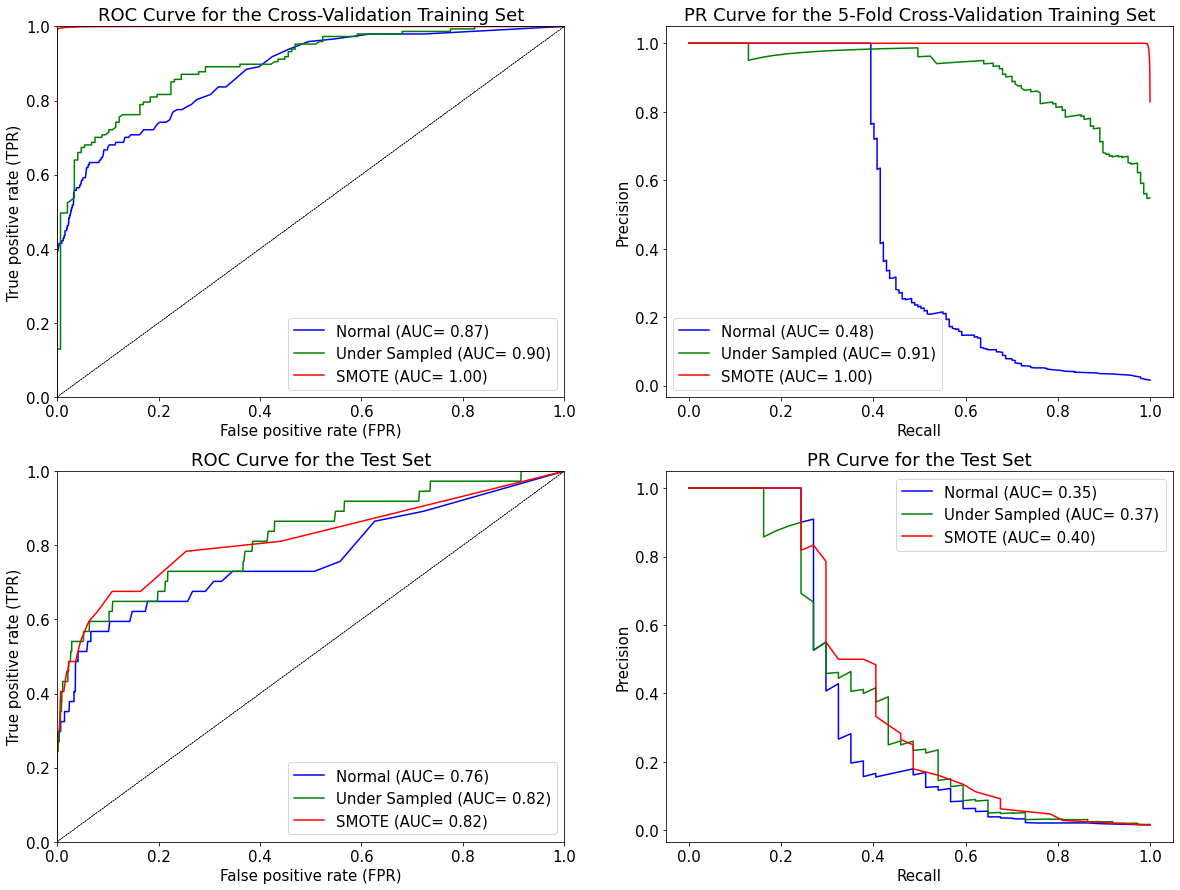

In [59]:
plt.figure(figsize = (20,15))

# Normal imbalanced distribution
rf_clf = joblib.load('../data/rf_clf.pkl') # Load trained model
model.plot_roc_pr_curves(rf_clf, X_train_scaled, y_train, X_test_scaled, y_test, cv_fold = 5,
                       color= 'b', label = 'Normal (AUC= %0.2f)')

# Under Sampled distribution
model.plot_roc_pr_curves(rf_und, X_train_scaled_und, y_train_und, X_test_scaled, y_test, cv_fold = 5,
                       color= 'g', label = 'Under Sampled (AUC= %0.2f)')
                     
# SMOTE distribution
model.plot_roc_pr_curves(rf_ovsm, X_train_scaled_ovsm, y_train_ovsm, X_test_scaled, y_test, cv_fold = 5,
                       color= 'r', label = 'SMOTE (AUC= %0.2f)') 

# F. AUC-ROC and AUC-PR for Cross-Validation vs. Test Sets

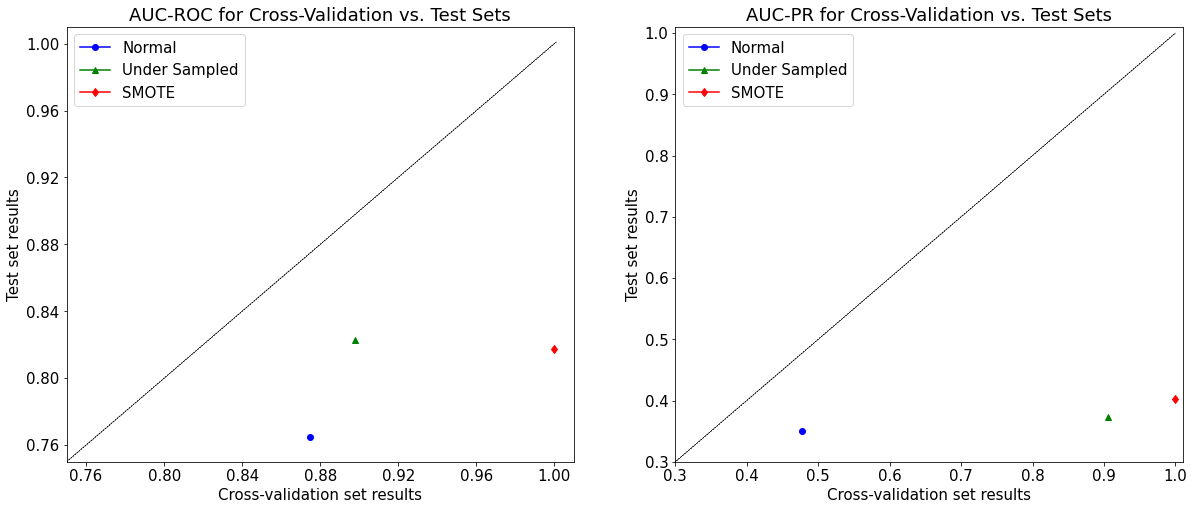

In [60]:
plt.figure(figsize = (20,8))

# Normal imbalanced distribution
rf_clf = joblib.load('../data/rf_clf.pkl') # Load trained model
model.plot_aucroc_aucpr(rf_clf, X_train_scaled, y_train, X_test_scaled, y_test, cv_fold = 5,
                       marker = 'o', color= 'b', label = 'Normal')

# Under Sampled distribution
model.plot_aucroc_aucpr(rf_und, X_train_scaled_und, y_train_und, X_test_scaled, y_test, cv_fold = 5,
                       marker = '^', color= 'g', label = 'Under Sampled')
                     
# SMOTE distribution
model.plot_aucroc_aucpr(rf_ovsm, X_train_scaled_ovsm, y_train_ovsm, X_test_scaled, y_test, cv_fold = 5,
                       marker = 'd', color= 'r', label = 'SMOTE') 